In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#### Dataset

* 3,670 images

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


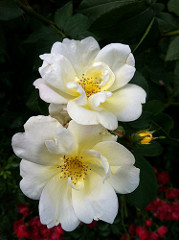

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

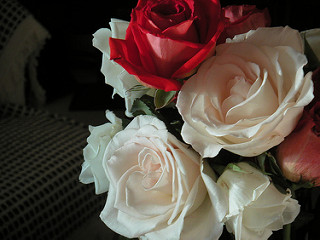

In [5]:
PIL.Image.open(str(roses[1]))

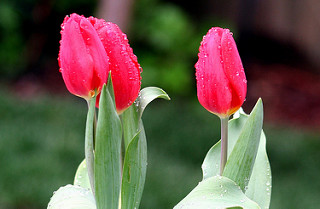

In [6]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

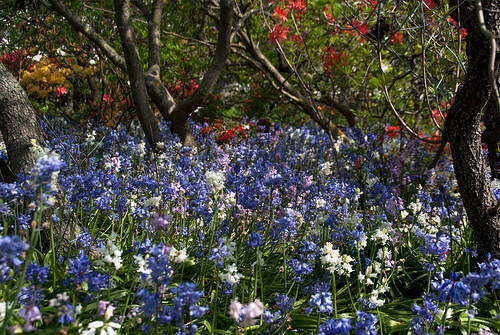

In [7]:
PIL.Image.open(str(tulips[1]))

#### Create a dataset

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='training'
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='validation'
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [12]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

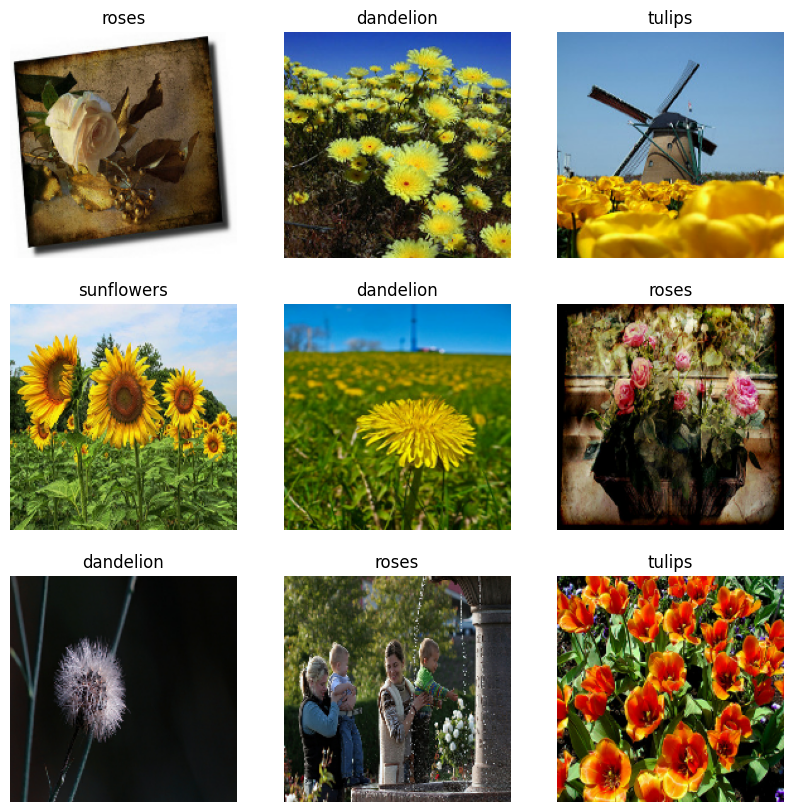

In [13]:
image_batch, labels_batch = next(iter(train_ds))
image_batch = tf.cast(image_batch, tf.uint8)

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i])
    plt.title(class_names[labels_batch[i]])
    plt.axis(False)

In [14]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


#### Configure the dataset for performance

* Using buffered prefetching, you can yield data from disk without having I/O become blocking.

In [15]:
print(tf.data.AUTOTUNE)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

-1


#### Standardize the data


Approach using `map` and `lambda`

In [16]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.97046


Approach adding layer to the model
```python
layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
```

#### Create Model

In [17]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

#### Compile the Model

In [18]:
def compile_model(model):
    model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

compile_model(model)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

#### Train the Model

In [20]:
def train_model(epochs):
    return model.fit(train_ds, epochs=epochs, validation_data=val_ds)

epochs=10
history = train_model(epochs)


Epoch 1/10
92/92 [==============================] - 6s 44ms/step - loss: 1.3657 - accuracy: 0.4172 - val_loss: 1.1622 - val_accuracy: 0.5341
Epoch 2/10
92/92 [==============================] - 3s 36ms/step - loss: 1.0352 - accuracy: 0.5933 - val_loss: 1.0250 - val_accuracy: 0.5777
Epoch 3/10
92/92 [==============================] - 3s 38ms/step - loss: 0.8457 - accuracy: 0.6785 - val_loss: 0.9185 - val_accuracy: 0.6403
Epoch 4/10
92/92 [==============================] - 3s 37ms/step - loss: 0.6725 - accuracy: 0.7544 - val_loss: 0.8944 - val_accuracy: 0.6608
Epoch 5/10
92/92 [==============================] - 3s 36ms/step - loss: 0.4828 - accuracy: 0.8273 - val_loss: 0.9649 - val_accuracy: 0.6471
Epoch 6/10
92/92 [==============================] - 3s 37ms/step - loss: 0.3161 - accuracy: 0.8961 - val_loss: 1.2146 - val_accuracy: 0.6253
Epoch 7/10
92/92 [==============================] - 3s 36ms/step - loss: 0.1532 - accuracy: 0.9550 - val_loss: 1.1909 - val_accuracy: 0.6608
Epoch 8/10
92

#### Visualize training results

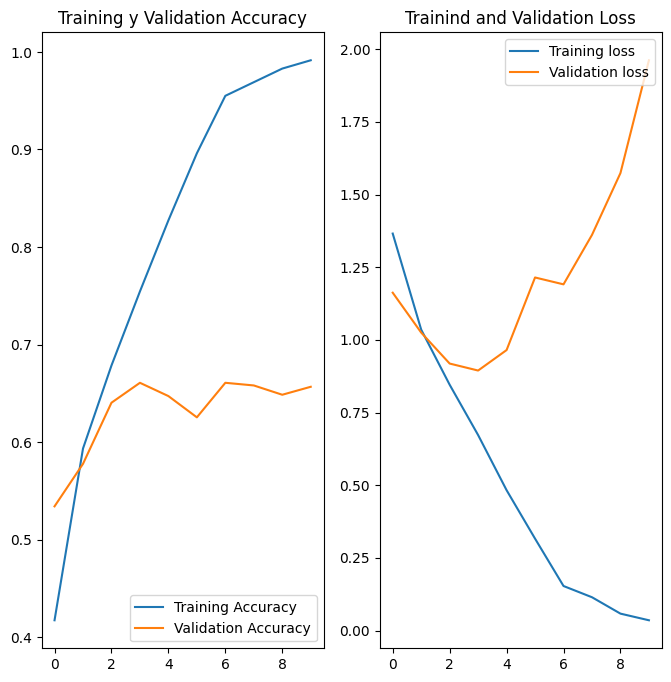

In [21]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training y Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.legend(loc='upper right')
    plt.title('Trainind and Validation Loss')

plot_results(history)

#### Data Augmentation

In [22]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

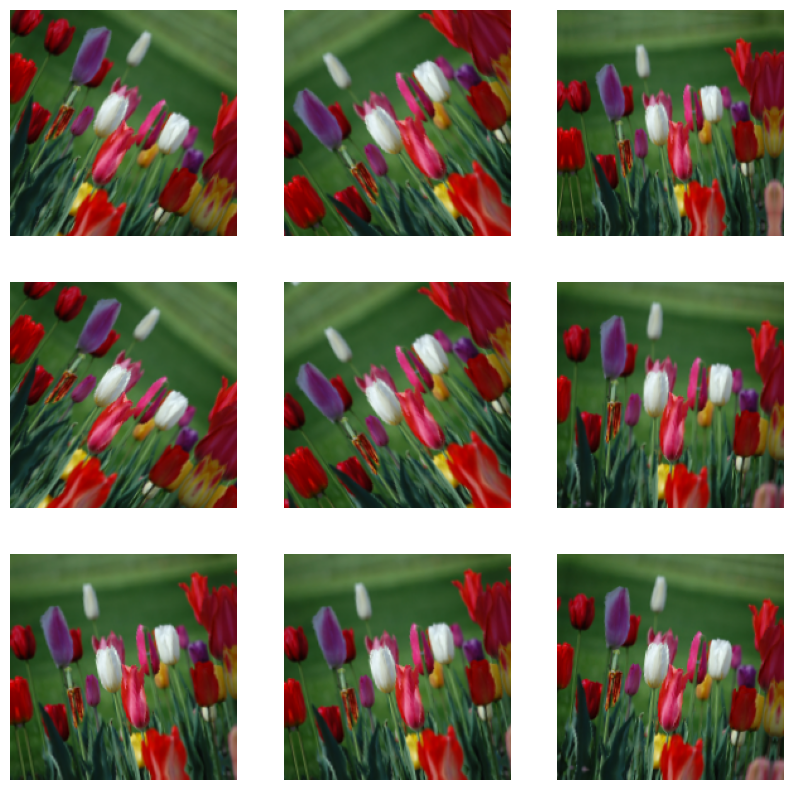

In [23]:
image_batch, _ = next(iter(train_ds))
image = tf.expand_dims(image_batch[0], 0)

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = tf.cast(data_augmentation(image)[0], tf.uint8)
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image)
    plt.axis(False)


In [24]:
model = Sequential([
    data_augmentation,      # added
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),    # added
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [25]:
compile_model(model)

In [26]:
epochs = 15
history = train_model(epochs)

Epoch 1/15
92/92 [==============================] - 10s 94ms/step - loss: 1.2845 - accuracy: 0.4309 - val_loss: 1.0712 - val_accuracy: 0.5613
Epoch 2/15
92/92 [==============================] - 8s 92ms/step - loss: 1.0289 - accuracy: 0.5947 - val_loss: 0.9522 - val_accuracy: 0.6226
Epoch 3/15
92/92 [==============================] - 9s 92ms/step - loss: 0.9270 - accuracy: 0.6386 - val_loss: 0.9619 - val_accuracy: 0.6349
Epoch 4/15
92/92 [==============================] - 8s 92ms/step - loss: 0.8579 - accuracy: 0.6768 - val_loss: 0.8489 - val_accuracy: 0.6771
Epoch 5/15
92/92 [==============================] - 9s 93ms/step - loss: 0.8259 - accuracy: 0.6771 - val_loss: 0.8686 - val_accuracy: 0.6676
Epoch 6/15
92/92 [==============================] - 8s 91ms/step - loss: 0.7594 - accuracy: 0.7119 - val_loss: 0.7976 - val_accuracy: 0.6880
Epoch 7/15
92/92 [==============================] - 8s 92ms/step - loss: 0.7370 - accuracy: 0.7163 - val_loss: 0.7984 - val_accuracy: 0.6826
Epoch 8/15
9

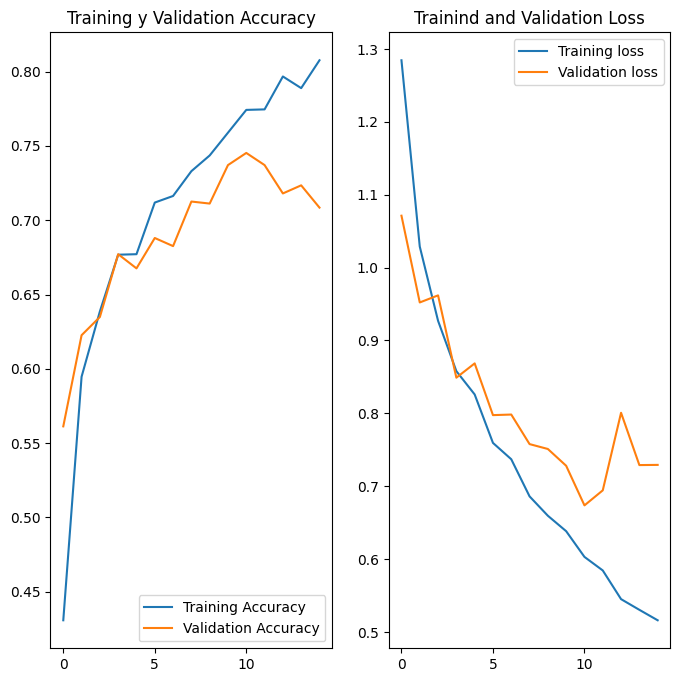

In [27]:
plot_results(history)

#### Predict on new data

In [28]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # tf.constant(img_array[np.newaxis, ...])

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print('This image most likely belongs to {} with a {:.2f} percent confidence.'.format(class_names[np.argmax(score)], 100 * np.max(score)))


1/1 [==============================] - 0s 183ms/step
This image most likely belongs to sunflowers with a 99.38 percent confidence.
